## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install dea-tools==0.2.8.dev100

In [ ]:
# pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import os
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

import datacube
import odc.geo.xr
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from odc.algo import mask_cleanup, xr_quantile

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides
from intertidal.elevation import (
    load_data,
    ds_to_flat,
    pixel_rolling_median,
    pixel_dem,
    pixel_uncertainty,
    flat_to_ds,
    elevation,
)
from intertidal.utils import load_config, export_intertidal_rasters


## Setup


### Set analysis parameters

In [3]:
# Set study area and config
# study_area = "pointstuart"
# config_path = "configs/dea_intertidal_config_development.yaml"
study_area = "832"
config_path = "configs/dea_intertidal_config.yaml"
# study_area = '836'
# config_path = 'configs/dea_intertidal_config_studyareas.yaml'

# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 30  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "FES2014"  # Tide model to use in analysis
tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = "TPXO9-atlas-v5",
# tide_model_dir = "/gdata1/data/tide_models",

##### Optional: load study area using interactive map

In [4]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
study_area = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4)

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Load data

In [5]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    s2_prod="s2_nbart_ndwi" if include_s2 else None,
    ls_prod="ls_nbart_ndwi" if include_ls else None,
    config_path=config_path,
    filter_gqa=filter_gqa)[["ndwi"]]

# Load data and close dask client
satellite_ds.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34821,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:42927,Total threads: 2
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/42171/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:44847,


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


## Pixel-based tides

In [19]:
# Model tides into every pixel in the three-dimensional (x by y by time) satellite dataset
tide_m, _ = pixel_tides(
    satellite_ds,
    resample=True,
    model=tide_model,
    directory=tide_model_dir,
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 322/322 [00:03<00:00, 96.48it/s] 


In [7]:
## Experimental: testing ebb flow filtering
# ebb_flow_da, tide_m_offset = pixel_ebb_flow(tide_m, offset_min=15)

In [20]:
# Set tide array pixels to nodata if the satellite data array pixels contain
# nodata. This ensures that we ignore any tide observations where we don't
# have matching satellite imagery
satellite_ds["tide_m"] = tide_m.where(
    ~satellite_ds.to_array().isel(variable=0).isnull()
)

## Pixel-based DEM creation

### Flatten array from 3D to 2D and drop pixels with no correlation with tide
Flatten array to only pixels with positive correlations between water observations and tide height. This greatly improves processing time by ensuring only a narrow strip of pixels along the coastline are analysed, rather than the entire x * y array:


![](../../data/figures/tide_array_flattening.JPG)

In [21]:
flat_ds, freq, corr, intertidal_candidates = ds_to_flat(
    satellite_ds, ndwi_thresh=0.0, min_freq=0.01, max_freq=0.99, min_correlation=0.2
)

Reducing analysed pixels from 20328 to 0 (0.00%)


### Pixel-wise rolling median
This function performs a rolling median calculation along the tide heights of our satellite images. 
It breaks our tide range into `windows_n` individual rolling windows, each of which covers `windows_prop_tide` of the full tidal range. 
For each window, the function returns the median of all tide heights and NDWI index values within the window, and returns an array with a new "interval" dimension that summarises these values from low to high tide.

In [22]:
interval_ds = pixel_rolling_median(
    flat_ds,
    windows_n=50,
    window_prop_tide=0.15,
    max_workers=None,
)

100%|██████████| 56/56 [00:00<00:00, 101.50it/s]


### Model intertidal elevation and uncertainty

In [23]:
# Model elevation
flat_dem = pixel_dem(
    interval_ds,
    flat_ds,
    ndwi_thresh,
)

In [26]:
# Model uncertainty
low, high, uncertainty, misclassified = pixel_uncertainty(
    flat_ds, flat_dem, ndwi_thresh, method="mad"
)

# Add arrays to dataset
flat_dem[["elevation_low", "elevation_high", "elevation_uncertainty"]] = (
    low,
    high,
    uncertainty,
)

## Unstack outputs and export

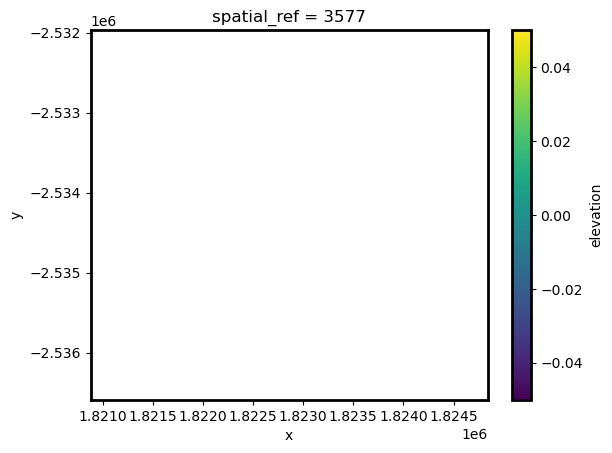

In [27]:
# Unstack elevation and uncertainty layers back into their original 
# spatial dimensions
ds = flat_to_ds(flat_dem, satellite_ds)
ds.elevation.plot(cmap="viridis")

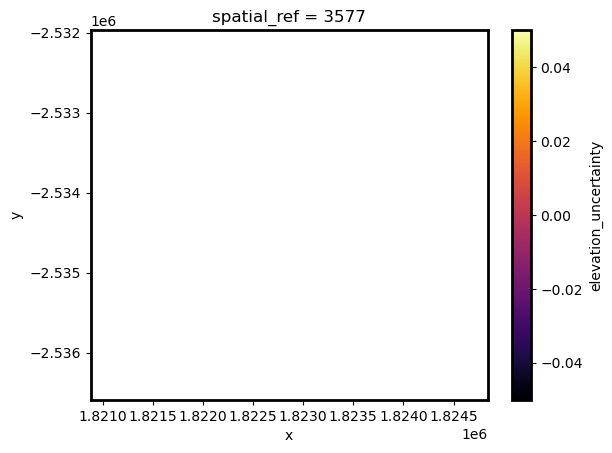

In [28]:
ds.elevation_uncertainty.plot(cmap="inferno")

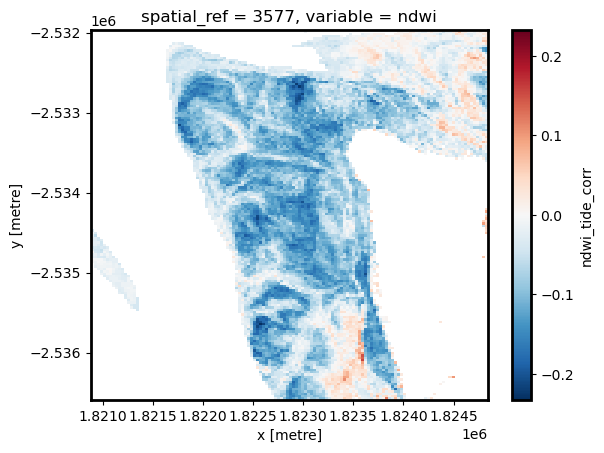

In [29]:
# Combine auxiliary layers into a new auxilary xr.Dataset
flat_ds_aux = xr.combine_by_coords(
    [freq, corr, intertidal_candidates, misclassified],
    fill_value={"intertidal_candidates": False},
)

# Unstack auxiliary layers back into their original spatial dimensions
ds_aux = flat_to_ds(flat_ds_aux, satellite_ds, stacked_dim="z")
ds_aux.ndwi_tide_corr.plot()

In [16]:
# import folium
# m = folium.Map(control_scale=True)
# layer1 = ds.elevation.odc.add_to(m)
# layer1.layer_name = "elevation"
# layer2 = ds.elevation_uncertainty.odc.add_to(m)
# layer2.layer_name = "elevation_uncertainty"

# # Zoom map
# m.fit_bounds(ds.odc.map_bounds())
# folium.LayerControl().add_to(m)
# display(m)

### Export to GeoTIFF files

In [31]:
# If a custom area was selected from the map, use "testing" for output files
if isinstance(study_area, Geometry):
    study_area = "testing"

# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}"
os.makedirs(output_dir, exist_ok=True)

# Export rasters
export_intertidal_rasters(
    ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}"
)
export_intertidal_rasters(
    ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}_debug"
)

## Experimental - not tested or working

### Investigate specific pixels

In [ ]:
# import pickle

# study_area = 'moreton'

# # Save flat_ds and interval_ds data to pickle file
# with open(f'{study_area}_flat_ds.pickle', 'wb') as handle:
#     pickle.dump(flat_ds, handle)
# with open(f'{study_area}_interval_ds.pickle', 'wb') as handle:
#     pickle.dump(interval_ds, handle)


In [ ]:
import pickle

# study_area = 'roebuck'
study_area = 'moreton'
# study_area = 'gulfcarpentaria2'

# Load flat_ds and interval_ds data from pickle file
with open(f'{study_area}_flat_ds.pickle', 'rb') as handle:
    flat_ds = pickle.load(handle)    
with open(f'{study_area}_interval_ds.pickle', 'rb') as handle:
    interval_ds = pickle.load(handle)

In [ ]:
# Unstack data back to x, y so we can select pixels by their coordinates
flat_ds_unstacked = flat_ds[["tide_m", "ndwi"]].unstack().sortby(["time", "x", "y"])
interval_ds_unstacked = interval_ds[["tide_m", "ndwi"]].unstack().sortby(["interval", "x", "y"])

In [ ]:
from shapely.geometry import LineString

# # Roebuck
# start = -1034545,-1985389
# end = -1038448,-1983292
# n = 5

# # Carpentaria1
# start = 450770.6,-1641979.8
# end = 451152.5,-1640577.0
# n = 5

# # Moreton
start = 2081464.0,-3140036.2
end = 2081003.8,-3140643.6
n = 7

# # Point Stuart
# start = -13098.3,-1287619.9
# end = -12187.1,-1286280.9
# start=-12672.6,-1287222.9
# end=-11678.7,-1287291.7
# n = 5


# # Gulf Carpentaria 2
# start = 506000.5,-1701434.1
# end = 508226.6,-1701232.9
# n = 5

# # Gulf Carpentaria 3
# start = 613819.0,-1740248.7
# end = 614185.7,-1739698.7
# n = 5

# Testing
start = -925456.88,-3733613.17
end = -925456.88,-3733613.17
n=2

fig, axes = plt.subplots(1, n, figsize=(25, 5))
axes = axes.flatten()

transect = LineString([start, end])

for i, prop in enumerate(np.linspace(0.0, 1, n)):
    x, y = transect.interpolate(prop, normalized=True).coords.xy

    # Extract pixels
    flat_ds_pixel = flat_ds_unstacked.sel(x=x, y=y, method='nearest')
    interval_ds_pixel = interval_ds_unstacked.sel(x=x, y=y, method='nearest')
    
    # Convert to dataframes
    flat_ds_df = flat_ds_pixel.to_dataframe()[['tide_m', 'ndwi']]
    interval_ds_df = interval_ds_pixel.to_dataframe()[['tide_m', 'ndwi']]
    # interval_rolling_df = interval_ds_unstacked.sel(x=x, y=y, method='nearest').rolling(interval=20, center=False, min_periods=1).mean().to_dataframe()[['tide_m', 'ndwi']]

    # ndwi_scaling = 1
    # interval_ds_df['ndwi_min'] = interval_ds_df.ndwi - (interval_ds_df.ndwi_std * ndwi_scaling)
    # interval_ds_df['ndwi_max'] = interval_ds_df.ndwi + (interval_ds_df.ndwi_std * ndwi_scaling)
    
    ndwi_thresh = 0.1
    flat_dem_pixel = pixel_dem(interval_ds_pixel, flat_ds_pixel, ndwi_thresh, 0)
    elevation_low_mad, elevation_high_mad, _, _ = pixel_uncertainty(flat_ds_pixel, flat_dem_pixel, ndwi_thresh, method="mad")
    elevation_low_q, elevation_high_q, _, _ = pixel_uncertainty(flat_ds_pixel, flat_dem_pixel, ndwi_thresh, method="quantile")
    
        
    # Plot 
    import seaborn as sns
    flat_ds_df.plot.scatter(x='tide_m', y='ndwi', c='black', s=2, ax=axes[i])
    # flat_ds_df['month'] = flat_ds_df.index.get_level_values('time').month
    # sns.scatterplot(flat_ds_df, x='tide_m', y='ndwi', hue='month', palette='twilight_shifted', ax=axes[i])
    # flat_ds_df.query("(tide_m > 0) & (ndwi < 0.7)").plot.scatter(x='tide_m', y='ndwi', c='red', s=5, ax=axes[i])
    interval_ds_df.plot(x='tide_m', y='ndwi', c='darkorange', ax=axes[i], lw=3)
    axes[i].axvspan(elevation_low_mad.item(), elevation_high_mad.item(), color='orange', alpha=0.3)
    axes[i].axvspan(elevation_low_q.item(), elevation_high_q.item(), color='blue', alpha=0.2)
    axes[i].axhline(ndwi_thresh, color='black', linestyle='-', lw=3, alpha=1)
    axes[i].axvline(flat_dem_pixel.elevation, color='black', linestyle='-', lw=3, alpha=1)  
    axes[i].set_ylim(-0.5, 1.1)

In [ ]:
pixel_uncertainty(flat_ds_pixel, flat_dem_pixel, 0.0, method="quantile")[3]

In [ ]:
# Extract pixel
x, y = transect.interpolate(0.8, normalized=True).coords.xy
flat_ds_pixel = flat_ds_unstacked.sel(x=x, y=y, method='nearest')
interval_ds_pixel = interval_ds_unstacked.sel(x=x, y=y, method='nearest')


thresholds = np.linspace(0, 0.2, 100)
out_mad = []
out_q = []
for thresh in thresholds:
    flat_dem_pixel = pixel_dem(interval_ds_pixel, flat_ds_pixel, thresh, 0)
    _, _, uncertainty_mad = pixel_uncertainty(flat_ds_pixel, flat_dem_pixel, thresh, method="mad")
    _, _, uncertainty_q = pixel_uncertainty(flat_ds_pixel, flat_dem_pixel, thresh, method="quantile")
    out_mad.append(uncertainty_mad.item())
    out_q.append(uncertainty_q.item())
    
plt.plot(thresholds, out_mad)
plt.plot(thresholds, out_q)

In [ ]:
# Calculate elevation
def elev_cert(interval_ds_pixel, flat_ds_pixel, thresh):
    elevation = interval_ds_pixel.tide_m.where(interval_ds_pixel.ndwi <= thresh).max()
    misclassified_wet = flat_ds_pixel.where(
        (flat_ds_pixel.ndwi > thresh) & (flat_ds_pixel.tide_m < elevation)
    )
    misclassified_dry = flat_ds_pixel.where(
        (flat_ds_pixel.ndwi < thresh) & (flat_ds_pixel.tide_m > elevation)
    )
    elev_min = misclassified_wet.tide_m.quantile(0.25, method="higher")
    elev_max = misclassified_dry.tide_m.quantile(0.75, method="lower")
    return (elev_max - elev_min).item()

thresholds = np.linspace(-0.1, 0.2, 100)
out = []
for thresh in thresholds:
    out.append(elev_cert(interval_ds_pixel, flat_ds_pixel, thresh=thresh))
    
plt.plot(thresholds, out)

In [ ]:
# Calculate elevation
thresh=0.05
elevation = interval_ds_pixel.tide_m.where(interval_ds_pixel.ndwi <= thresh).max()
# misclassified_wet = flat_ds_pixel.where(
#     (flat_ds_pixel.ndwi > thresh) & (flat_ds_pixel.tide_m < elevation)
# )
# misclassified_dry = flat_ds_pixel.where(
#     (flat_ds_pixel.ndwi < thresh) & (flat_ds_pixel.tide_m > elevation)
# )
# elev_min = misclassified_wet.tide_m.quantile(0.25, method="higher")
# elev_max = misclassified_dry.tide_m.quantile(0.75, method="lower")

misclassified_ds = flat_ds_pixel.where(
    ((flat_ds_pixel.ndwi > thresh) & (flat_ds_pixel.tide_m < elevation))
    | ((flat_ds_pixel.ndwi < thresh) & (flat_ds_pixel.tide_m > elevation))
)

testing = misclassified_ds.tide_m.quantile((0.25, 0.75), method="weibull")
elev_min = np.minimum(testing.sel(quantile=0.25), elevation)
elev_max = np.maximum(testing.sel(quantile=0.75), elevation)

fig, ax = plt.subplots(1, 1)
flat_ds_df.plot.scatter(x="tide_m", y="ndwi", c="black", alpha=1, s=1, ax=ax)
# misclassified_wet.to_dataframe()[["tide_m", "ndwi"]].plot.scatter(x="tide_m", y="ndwi", c="red", alpha=1, s=3, ax=ax)
# misclassified_dry.to_dataframe()[["tide_m", "ndwi"]].plot.scatter(x="tide_m", y="ndwi", c="red", alpha=1, s=3, ax=ax)
interval_ds_df.plot(x="tide_m", y="ndwi", c="darkorange", ax=ax, lw=3)
ax.axhline(thresh, color="black", linestyle="--", lw=1.5)
ax.axvline(elevation, color="black", linestyle="--", lw=1.5)
ax.axvspan(elev_min, elev_max, alpha=0.2, color='grey')


#         1. "inverted_cdf" (*)
#         2. "averaged_inverted_cdf" (*)
#         3. "closest_observation" (*)
#         4. "interpolated_inverted_cdf" (*)
#         5. "hazen" (*)
#         6. "weibull" (*)
#         7. "linear"  (default)
#         8. "median_unbiased" (*)
#         9. "normal_unbiased" (*)

#     The first three methods are discontiuous. The following discontinuous
#     variations of the default "linear" (7.) option are also available:

#         * "lower"
#         * "higher"
#         * "midpoint"
#         * "nearest"

In [ ]:
smoothed_ds = interval_ds.copy()   #.rolling(interval=20, center=False, min_periods=1).mean()

In [ ]:
smoothed_ds = smoothed_ds.interp(coords={'interval': np.linspace(1, 114, 300)})


In [ ]:
smoothed_ds = interval_ds.rolling(interval=10, center=False, min_periods=1).mean()

In [ ]:
smooth_radius = 20
ndwi_thresh = 0.1


########################
# Elevation extraction #
########################

# Smooth tidal intervals using a rolling mean
if smooth_radius > 1:
    smoothed_ds = interval_ds.rolling(
        interval=smooth_radius, center=False, min_periods=1
    ).mean()
else:
    smoothed_ds = interval_ds

# Identify the max tide per pixel where rolling median NDWI == land.
# This represents the tide height at which the pixel transitions from
# dry to wet as it gets inundated by tidal waters.
tide_dry = smoothed_ds.tide_m.where(smoothed_ds.ndwi <= ndwi_thresh)
tide_thresh = tide_dry.max(dim="interval")

# Remove any pixel where tides max out (i.e. always land)
tide_max = smoothed_ds.tide_m.max(dim="interval")
always_dry = tide_thresh >= tide_max
flat_elev = tide_thresh.where(~always_dry).drop("variable")


###############
# Uncertainty #
###############

# Identify observations that were misclassifed by our modelled
# elevation: e.g. wet observations (NDWI > threshold) at lower tide
# heights than our modelled elevation, or dry observations (NDWI <
# threshold) at higher tide heights than our modelled elevation.
misclassified_wet = (flat_ds.ndwi > ndwi_thresh) & (flat_ds.tide_m < flat_elev)
misclassified_dry = (flat_ds.ndwi < ndwi_thresh) & (flat_ds.tide_m > flat_elev)
misclassified_all = misclassified_wet | misclassified_dry
misclassified_ds = flat_ds.where(misclassified_all).drop("variable")

# Calculate interquartile tide height range of our misclassified
# observations to obtain lower and upper uncertainty bounds around our
# modelled elevation.
misclassified_q = xr_quantile(
    src=misclassified_ds.dropna(dim="time", how="all")[["tide_m"]],
    quantiles=[0.25, 0.75],
    nodata=np.nan,
).tide_m.fillna(flat_elev)

# Clip min and max uncertainty to modelled elevation to ensure lower
# bounds are not above modelled elevation (and vice versa)
flat_elev_low = np.minimum(misclassified_q.sel(quantile=0.25, drop=True), flat_elev)
flat_elev_high = np.maximum(misclassified_q.sel(quantile=0.75, drop=True), flat_elev)

# Combine into a single xr.Dataset
ds = xr.merge(
    [
        flat_elev.rename("elevation"),
        flat_elev_low.rename("elevation_low"),
        flat_elev_high.rename("elevation_high"),
    ]
)

# Subtract low from high DEM to get a single confidence layer
# Note: This may produce unexpected results at the top and bottom
# of the intertidal zone, as the low and high DEMs may not be
# currently be properly masked to remove always wet/dry terrain
ds["elevation_uncertainty"] = ds.elevation_high - ds.elevation_low

In [ ]:
misclassified_wet = (flat_ds.ndwi > thresh) & (flat_ds.tide_m < flat_dem)
misclassified_dry = (flat_ds.ndwi < thresh) & (flat_ds.tide_m > flat_dem)
misclassified_all = misclassified_wet | misclassified_dry
misclassified_ds = flat_ds.where(misclassified_all)

# misclassified_q = misclassified_ds.tide_m.quantile(
#     (0.25, 0.75), dim="time", method="midpoint"
# ).fillna(flat_dem)
misclassified_q = xr_quantile(
    src=misclassified_ds.dropna(dim="time", how="all")[["tide_m"]],
    quantiles=[0.25, 0.75],
    nodata=np.nan,
).tide_m.fillna(flat_dem)
elev_min = np.minimum(misclassified_q.sel(quantile=0.25), flat_dem)
elev_max = np.maximum(misclassified_q.sel(quantile=0.75), flat_dem)

dem_low = elev_min.unstack("z").reindex_like(satellite_ds).transpose("y", "x")
dem_high = elev_max.unstack("z").reindex_like(satellite_ds).transpose("y", "x")


In [ ]:
# misclassified_all.mean(dim='time').unstack("z").reindex_like(satellite_ds).transpose("y", "x").plot()

In [ ]:
(dem_high - dem_low).rename('Uncertainty (m)').plot.imshow(cmap='inferno', interpolation='bilinear', size=8, robust=True)
plt.gca().set_facecolor('#2E2E2E')
plt.gca().set_title('Per-pixel uncertainty')

In [ ]:
dem.odc.write_cog('testing_elevation.tif', overwrite=True)
# dem_low.odc.write_cog('testing_elevation_low.tif', overwrite=True)
# dem_high.odc.write_cog('testing_elevation_high.tif', overwrite=True)

In [ ]:
# .unstack("z").reindex_like(satellite_ds).transpose("y", "x", "quantile")

In [ ]:
misclassified_wet = flat_ds.where(
    (flat_ds.ndwi > thresh) & (flat_ds.tide_m < flat_dem)
)
misclassified_dry = flat_ds.where(
    (flat_ds.ndwi < thresh) & (flat_ds.tide_m > flat_dem)
)
elev_min = misclassified_wet.tide_m.quantile(0.25, dim='time', method="midpoint")
elev_max = misclassified_dry.tide_m.quantile(0.75, dim='time', method="midpoint")

dem_low = elev_min.unstack("z").reindex_like(satellite_ds).transpose("y", "x").fillna(dem)
dem_high = elev_max.unstack("z").reindex_like(satellite_ds).transpose("y", "x").fillna(dem)

In [ ]:
(dem_high - dem_low).rename('Uncertainty (m)').plot.imshow(cmap='inferno', interpolation='bilinear', size=8, robust=True)
plt.gca().set_facecolor('#2E2E2E')
plt.gca().set_title('Per-pixel uncertainty')

In [ ]:
(dem_high - dem_low).rename('Uncertainty (m)').plot.imshow(cmap='inferno', interpolation='bilinear', size=8, robust=True)
plt.gca().set_facecolor('#2E2E2E')
plt.gca().set_title('Per-pixel uncertainty')


In [ ]:
(dem_high - dem_low).rename('Uncertainty (m)').odc.write_cog('test.tif', overwrite=True)

In [ ]:
dem.odc.write_cog('test_dem.tif')

In [ ]:
dem.plot()

In [ ]:
x, y = transect.interpolate(0.7, normalized=True).coords.xy
interval_ds_pixel = interval_ds_unstacked.sel(x=x, y=y, method='nearest')
rate = interval_ds_pixel.ndwi.rolling(interval=20).mean().differentiate('interval')
change = rate.differentiate('interval')
min_change = change.argmin()
max_change = rate.isel(interval=slice(None, min_change.item())).argmax()

interval_ds_pixel.isel(interval=max_change).to_dataframe()[['tide_m', 'ndwi', 'ndwi_std']].plot.scatter(x='tide_m', y='ndwi', zorder=5, s=30)
interval_ds_pixel.isel(interval=min_change).to_dataframe()[['tide_m', 'ndwi', 'ndwi_std']].plot.scatter(x='tide_m', y='ndwi', zorder=5, s=30, ax=plt.gca())
interval_ds_pixel.to_dataframe()[['tide_m', 'ndwi', 'ndwi_std']].plot(x='tide_m', y='ndwi', c='darkorange', lw=3, ax=plt.gca())

In [ ]:
rate.isel(interval=slice(None, min_change.item())).plot()

In [ ]:
interval_ds_df.derivitive('interval').plot()

In [ ]:
accumulated height gain along x dimension

In [ ]:
flat_ds_unstacked.sel(x=x, y=y, method='nearest')  #.rolling(time=20, min_periods=1).median().

In [ ]:
# interval_ds_df.ndwi.plot.hist(bins=30)

In [ ]:
# x, y = LineString([start, end]).interpolate(0.0, normalized=True).coords.xy
# interval_ds_df = interval_ds_unstacked.sel(x=x, y=y, method='nearest')  #.to_dataframe()[['tide_m', 'ndwi', 'ndwi_std']]
# interval_ds_df.ndwi.differentiate("interval").plot()  
# interval_ds_df.ndwi.differentiate("interval").differentiate("interval").plot()   #.plot() .rolling(interval=5, center=True, min_periods=5).mean()

In [ ]:
# from random import randint
# flat_ds_unstacked.isel(z=randint(0, 10))

### Investigate faster ways to do rolling median

In [ ]:
windows_n=100
window_prop_tide=0.15

tide_max = flat_ds.tide_m.max(dim="time")
tide_min = flat_ds.tide_m.min(dim="time")
tide_range = tide_max - tide_min

window_radius_tide = tide_range * window_prop_tide
window_spacing_tide = tide_range / windows_n
window_offset = int((windows_n * window_prop_tide) / 2.0)

i= 50
thresh_centre = tide_min + (i * window_spacing_tide)
thresh_min = thresh_centre - window_radius_tide
thresh_max = thresh_centre + window_radius_tide

In [ ]:
import multiprocess as mp

In [ ]:
from intertidal.elevation import rolling_tide_window

In [ ]:
from concurrent.futures import ProcessPoolExecutor
import time

# Parallelise pixel-based rolling median using `concurrent.futures`
with ProcessPoolExecutor(max_workers=30) as executor:
    # Create rolling intervals to iterate over
    
    def foo_pool(x):
        # time.sleep(0.2)
        return satellite_ds.ndwi * satellite_ds.ndwi * satellite_ds.ndwi

    # Place itervals in a iterable along with params for each call
    to_iterate = range(10)

    # Apply func in parallel
    out_list = list(
        # tqdm(
            executor.map(foo_pool, to_iterate),
            # total=len(list(rolling_intervals)),
        # )
    )

In [ ]:
# import multiprocessing as mp
import time

def foo_pool(x):
    time.sleep(0.2)
    return x*x

result_list = []
def log_result(result):
    # This is called whenever foo_pool(i) returns a result.
    # result_list is modified only by the main process, not the pool workers.
    result_list.append(result)

def apply_async_with_callback():
    pool = mp.Pool(processes=15)
    for i in range(5):
        pool.apply_async(rolling_tide_window, args = (i, flat_ds, window_spacing_tide, window_radius_tide, tide_min ), callback = log_result)
    pool.close()
    pool.join()
    print(result_list)

if __name__ == '__main__':
    apply_async_with_callback()

In [ ]:
0.2 * 100 / 10

In [ ]:
# flat_ds.tide_m.dropna(dim='time', how='all')

In [ ]:
max_tide = flat_ds.tide_m.max(dim='z')
min_tide = flat_ds.tide_m.min(dim='z')

In [ ]:
%%timeit -n 1 -r 1
flat_ds.where(
        (flat_ds.tide_m >= thresh_min) & (flat_ds.tide_m <= thresh_max)
    )

In [ ]:
tide_m_np = flat_ds.tide_m.values.copy()
ndwi_np = flat_ds.ndwi.values.copy()
thresh_min_np = thresh_min.values.copy() 
thresh_max_np = thresh_max.values.copy() 

In [ ]:
flat_ds.copy(data=

In [ ]:
%%timeit -n 1 -r 1
bool_array = (tide_m_np >= thresh_min_np) & (tide_m_np <= thresh_max_np)
# np.where(bool_array, tide_m_np, np.nan)
# np.where(bool_array, ndwi_np, np.nan)
ndwi_np[bool_array]
tide_m_np[bool_array]

In [ ]:
%%timeit -n 1 -r 1

masked_ds = flat_ds.where(
        (flat_ds.tide_m >= thresh_min) & (flat_ds.tide_m <= thresh_max)
    )

# valid = ~masked_ds.ndwi.isnull()
# masked_ds = masked_ds.sel(time = valid.mean(dim='z') > 0)


# ds_agg = xr_quantile(src=masked_ds, quantiles=[0.1, 0.5, 0.9], nodata=np.nan)
masked_ds.median(dim='time')
masked_ds.ndwi.std(dim="time")
# valid.sum(dim="time")

In [ ]:
# masked_ds.dropna(dim='time', how='all')    #.sel((masked_ds.tide_m.isnull()).mean(dim='z') == 1)

In [ ]:
import os
os.cpu_count()

In [ ]:
# %%timeit -n 1 -r 1  # original = 1 min 23; after = 
interval_ds = pixel_rolling_median(
    flat_ds, windows_n=100,  # default 100
    window_prop_tide=0.15,  # default 0.15
    max_workers=64  # default 64
)

In [ ]:
import numpy as np
import xarray as xr
from timeit import timeit
import numba as nb


def time_solution(solution, number=1):
    return timeit(
        f"{solution.__name__}(data, threshold_value, low, high)",
        setup=f"from __main__ import data, threshold_value, low, high, {solution.__name__}",
        number=number,
    )


def your_solution(data, threshold_value, low, high):
    ds = xr.Dataset(
        data_vars={
            "a": xr.DataArray(data, dims=("time", "y", "x")),
            "b": xr.DataArray(threshold_value, dims=("time", "y", "x")),
        }
    )

    result = ds.a.where((ds.b > low) & (ds.b < high)).median(dim="time")

    return result


@nb.jit(
    "float32[:, :](float32[::1, :, :], float32[::1, :, :], float32[::1, :, :], float32[::1, :, :])",
    nopython=True,
    nogil=True,
)
def numba_magic(data, threshold_value, low, high):
    output = np.empty(data.shape[1:], dtype=np.float32)

    for height in range(data.shape[1]):
        for width in range(data.shape[2]):
            threshold = threshold_value[:, height, width]
            mask = (low[:, height, width] < threshold) & (
                threshold < high[:, height, width]
            )
            buffer = np.where(mask, data[:, height, width], np.nan)
            output[height, width] = np.nanmedian(buffer)

    return output


# Time solutions
# ==============

shape = (100, 3000, 3000)
rng = np.random.default_rng()
data = rng.random(shape).astype(np.float32, order="F")
threshold_value = rng.random(shape).astype(np.float32, order="F")

random_vals = (rng.random(shape) / 10).astype(np.float32, order="F")
low = 0.5 - random_vals
high = 0.5 + random_vals


# assert equality of solutions
expected = np.asarray(your_solution(data, threshold_value, low, high))
actual_numba = numba_magic(data, threshold_value, low, high)
assert np.allclose(expected, actual_numba, equal_nan=True)

# compare timings of solutions
repeats = 1
print("""
Timings
-------""")
print(f"Your Approach: {time_solution(your_solution, repeats)/repeats:.4f} s")
print(f"Numba JIT: {time_solution(numba_magic, repeats)/repeats:.4f} s")

In [ ]:
%%timeit -n 1 -r 1
masked_ds = flat_ds.tide_m.where(
        (flat_ds.tide_m >= 0) & (flat_ds.tide_m <= 0.5)
)

In [ ]:
# flat_ds.tide_m.values.is
a = flat_ds.tide_m.values.copy()


In [ ]:
%%timeit -n 1 -r 1
a[~((a >= 0) & (a <= 0.5))] = np.nan

In [ ]:
np.allclose(a, masked_ds.values, equal_nan=True)

### Morphological cleaning to remove narrow inland streams

In [ ]:
# # Clean data using morphological opening to remove narrow inland 
# # streams and waterbodies
# clean=[("opening", 20), ("dilation", 10)]
# to_keep = mask_cleanup(extents_da < 100, mask_filters=clean)
# dem_clean = dem.where(to_keep)

# # Export to file
# dem_clean.odc.write_cog(
#         fname=f"data/interim/pixel_{fname}_{suffix}_cleaned.tif", overwrite=True
#     )

In [ ]:
# test = ds.tide_m.mean(dim=['x', 'y'])

### Remove water not attached to ocean

In [ ]:
# from skimage.measure import label, regionprops

In [ ]:
# # First, break boolean array into unique, discrete regions/blobs
# blobs = xr.apply_ufunc(label, to_keep, 0, False, 1)

# # Get blob ID for each blob inside ocean area
# ocean = dc.load(product="geodata_coast_100k", like=ds.odc.geobox.compat).land == 0
# ocean_blobs = np.unique(blobs.where(ocean, 0))

# # Return only blobs that contained tide modelling point
# ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

In [ ]:
# ocean_mask.plot()

In [ ]:
# # First, break boolean array into unique, discrete regions/blobs
# blobs = xr.apply_ufunc(label, ds, 1, False, 1)

# # Get blob ID for each tidal modelling point
# x = xr.DataArray(tide_points_gdf.geometry.x, dims="z")
# y = xr.DataArray(tide_points_gdf.geometry.y, dims="z")
# ocean_blobs = np.unique(blobs.interp(x=x, y=y, method="nearest"))

# # Return only blobs that contained tide modelling point
# ocean_mask = blobs.isin(ocean_blobs[ocean_blobs != 0])

# # Dilate mask so that we include land pixels on the inland side
# # of each shoreline to ensure contour extraction accurately
# # seperates land and water spectra
# if dilation:
#     ocean_mask = xr.apply_ufunc(binary_dilation, ocean_mask, disk(dilation))

# return ocean_mask

### Regression experiment

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
ds_subset = interval_ds.where((interval_ds.ndwi > 0.05) & (interval_ds.ndwi < 0.25))
linreg = lag_linregress_3D(x=ds_subset.tide_m, y=ds_subset.ndwi, first_dim='interval')

In [ ]:
# linreg.intercept.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
# linreg.slope.unstack("z").reindex_like(ds).plot(robust=True)

In [ ]:
testing = ((0 - linreg.intercept) / linreg.slope).where(linreg.pval < 0.01).unstack("z").reindex_like(ds)  #.plot.imshow(vmin=-1, vmax=0.5)

In [ ]:
testing = testing.where(testing > ds_subset.tide_m.min())

In [ ]:
testing.T.odc.write_cog(fname=f'data/interim/pixel_linreg7.tif', overwrite=True)

In [ ]:
y = mx + a
(y - a) / m

In [ ]:
ds.geobox

In [ ]:
quantile_ds.tide_m.where(quantile_ds.ndwi <= 0.1).dropna(dim='z', how='all')

In [ ]:
(tide_argmax + 1).unstack("z").reindex_like(ds).T.plot()

In [ ]:
tide_dry.isel(interval=(tide_argmax - 1).clip(0, len(tide_dry.interval) - 1))

In [ ]:
tide_dry.isel(tide_argmax)

In [ ]:
tide_argmax + 1

In [ ]:
tide_dry.dropna(dim='interval', how='all').argmax(dim='interval', axis=1)

In [ ]:
interval_ds

In [ ]:
# # Output name
# fname = 'testing1'
# # fname = aoi.lower().replace(' ', '')

# # Calculate 
# confidence = interval_ds.ndwi_std.mean(dim='interval')
# min_thresh = (0 - 0.5 * confidence)
# max_thresh = (0 + 0.5 * confidence)

# for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
#     dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
#     print(f'Exporting {dem_fname}')
    
#     # Identify the max tide per pixel where NDWI == land
#     tide_thresh = interval_ds.tide_m.where(interval_ds.ndwi <= thesh).max(dim='interval')
#     tide_max = interval_ds.tide_m.max(dim='interval')
    
#     # Remove any pixel where tides max out (i.e. always land)
#     dem = tide_thresh.where(tide_thresh < tide_max)
    
#     # Export DEM file  
# #     dem.T.odc.write_cog(fname=dem_fname, overwrite=True)
#     dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).T.odc.write_cog(fname=dem_fname, overwrite=True)
    

# # Export NDWI standard deviation/confidence file
# confidence.T.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

In [ ]:
# dem.where(~((freq > 0) & tide_thresh.isnull()), dem.min()).plot()

In [ ]:
# dem.where(~(tide_thresh.isnull() & (freq > 0.90)), dem.min()).plot()

In [ ]:
interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest')

In [ ]:
x, y = -1156521.12372093, 7712141.96160016
ndwi_thresh = 0.0

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sortby(["interval", "x", "y"]).sel(x=x,  y=y, method='nearest')
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)


# clipped = pixel_rolling.where((pixel_rolling.ndwi > 0) & (pixel_rolling.ndwi < 0.1)).dropna()

# ax.plot(clipped.tide_m, clipped.ndwi, '-o', color='green')
# from scipy import stats
# linreg = stats.linregress(x=clipped.tide_m, y=clipped.ndwi)
# x = np.linspace(pixel_raw.tide_m.min(), pixel_raw.tide_m.max())
# # ax.plot(x, [linreg.slope * i + linreg.intercept for i in x], color='green', linestyle='--')
# tide_thresh_3 = (ndwi_thresh - linreg.intercept) / linreg.slope

# rolling2 = pixel_raw.sort_values('tide_m').rolling(100, center=True, min_periods=1).median()
# ax.plot(rolling2.tide_m, rolling2.ndwi, '-o', color='red')



# tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
# tide_thresh_2 = pixel_rolling.tide_m.iloc[max_ind + 1]

# ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
# ax.axvline(tide_thresh_2, color='red', linestyle='--', lw=0.8, alpha=0.5)
# ax.axvline(tide_thresh_3, color='green', linestyle='--', lw=2, alpha=0.5)
# ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
x, y = 801144.14604825, 8189103.58475355
ndwi_thresh = 0.1

# Extract rolling and raw data
pixel_rolling = interval_ds.squeeze('quantile').unstack().sel(x=x,  y=y, method='nearest').to_dataframe().reset_index()
pixel_raw = ds.sel(x=x,  y=y, method='nearest').sortby('tide_m')
# pixel_raw['ndwi'] = (pixel_raw.ndwi > 0.1).where(~pixel_raw.ndwi.isnull())
# pixel_rolling = pixel_raw.rolling(time=100, min_periods=1).mean().to_dataframe().reset_index()
pixel_raw = pixel_raw.to_dataframe().reset_index()

# To plot
pixel_to_plot = pixel_rolling
pixel_to_plot_mean = pixel_to_plot.rolling(20, center=False, min_periods=None).mean()


# pixel_savgol = pixel_rolling.copy()
# pixel_savgol['ndwi'] = savgol_filter(pixel_savgol.ndwi.values, 50, 1)

# Calculate thresholds
land_tides = pixel_to_plot.where((pixel_to_plot.ndwi) < ndwi_thresh)
max_ind = land_tides.tide_m.argmax()


# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(x=pixel_raw.tide_m, y=pixel_raw.ndwi)
ax.plot(pixel_to_plot.tide_m, pixel_to_plot.ndwi, '-o', color='orange')
ax.plot(pixel_to_plot_mean.tide_m, pixel_to_plot_mean.ndwi, '-o', color='green')
# ax.plot(pixel_savgol.tide_m, pixel_savgol.ndwi, '-o', color='blue')
tide_thresh_1 = land_tides.tide_m.iloc[max_ind]
ax.axvline(tide_thresh_1, color='orange', linestyle='--', lw=2, alpha=0.5)
ax.axhline(ndwi_thresh, color='black', linestyle='--', lw=0.8, alpha=0.5)

In [ ]:
(pixel_rolling.ndwi * (10* pixel_rolling.ndwi.abs())).plot()

In [ ]:
ds_sub = ds.sel(x=x,  y=y, method='nearest')


ds_sub.sel(time=(ds_sub.ndwi < 0) & (ds_sub.tide_m > 0.25)).time

In [ ]:
from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_rolling.ndwi.values, 50, 2) # window size 51, polynomial order 3
plt.plot(yhat)

In [ ]:
test = np.array([-0.5, -0.2, -0.01, 0, 0.01, 0.2, 0.5])

In [ ]:
import scipy.stats
plt.plot(scipy.stats.norm.pdf(test, loc=0, scale=1))

In [ ]:
from skimage import exposure

In [ ]:
plt.plot(test)

In [ ]:
plt.plot(exposure.adjust_gamma(np.abs(test), 2))

In [ ]:



from scipy.signal import savgol_filter
yhat = savgol_filter(pixel_raw.ndwi.values, 25, 3) # window size 51, polynomial order 3

pixel_rolling.ndwi.plot()
plt.plot(yhat)

In [ ]:
pixel_raw.ndwi.plot()

In [ ]:
interval_ds.ndwi2

In [ ]:
clipped_test = pixel_rolling.where((pixel_rolling.ndwi > -0.1) & (pixel_rolling.ndwi < 0.1)).dropna().rolling(5, center=True).mean()
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

diff = clipped_test.ndwi.diff() / clipped_test.ndwi.index.to_series().diff()
plt.plot(clipped_test.tide_m, diff, '-o', color='red')

plt.axvline(clipped_test.tide_m.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.axhline(clipped_test.ndwi.iloc[diff.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)

In [ ]:
plt.plot(clipped_test.tide_m, clipped_test.ndwi, '-o', color='green')

In [ ]:
pdf = gaussian_kde(pixel_rolling.ndwi.values, bw_method=0.5, weights=scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))
x = np.linspace(-0.5, 0.5, 200)
y = pdf(x)
plt.axvline(x[y.argmax()], color='orange', linestyle='--', lw=2, alpha=0.5)
plt.plot(x, y, label='kde')

In [ ]:
from scipy.stats import gaussian_kde


In [ ]:
import scipy.stats
plt.scatter(pixel_rolling.ndwi.values, scipy.stats.norm.pdf(pixel_rolling.ndwi.values, loc=0, scale=0.1))

In [ ]:
pixel_raw.tide_m.min()

In [ ]:
pixel_raw.ndwi.plot.density(bw_method=0.05)

In [ ]:
pixel_rolling.ndwi.plot()
(pixel_rolling.ndwi.diff() / pixel_rolling.ndwi.index.to_series().diff()).plot()

In [ ]:
from scipy.signal import savgol_filter
w = savgol_filter(y.sort_values('ndwi').ndwi, 5, 2)
w

In [ ]:
y.sort_values('tide_m').ndwi

In [ ]:
# tide_thresh_2 = 


In [ ]:
pixel_rolling.where(pixel_rolling.ndwi < 0).tide_m.argmax()

In [ ]:
x, y = 642456.7107189415, 8275569.497920433
pixel = interval_ds.sel(x=x,  y=y, method='nearest')
df_median = pixel.to_dataframe().reset_index()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_m, y=df_median.ndwi)
tide_thresh_1 = df_median.where(df_median.ndwi < 0).tide_m.max()
tide_thresh_2 = df_median.where(df_median.ndwi > 0).tide_m.min()
ax.axvline((tide_thresh_1 + tide_thresh_2) / 2)
ax.axhline(0)

### Elevation calculation

In [ ]:
# Output name
fname = 'testing1'
# fname = aoi.lower().replace(' ', '')

# Calculate 
min_thresh = (0 - 0.5 * s2_stdev_mean)
max_thresh = (0 + 0.5 * s2_stdev_mean)

for thresh_name, thesh in {'': 0, '_low': min_thresh, '_high': max_thresh}.items():
    
    dem_fname = f'data/interim/pixel_dem_{fname}{thresh_name}.tif'
    print(f'Exporting {dem_fname}')
    
    # Identify the max tide per pixel where NDWI == land
    tide_thresh = ds.tide_m.where(s2_median <= thesh).max(dim='tide_n')
    tide_max = ds.tide_m.max(dim='tide_n')
    
    # Remove any pixel where tides max out (i.e. always land)
    dem = tide_thresh.where(tide_thresh < tide_max)
    
    # Export DEM file  
    dem.odc.write_cog(fname=dem_fname, overwrite=True)

# Export NDWI standard deviation/confidence file
s2_stdev_mean.odc.write_cog(fname=f'data/interim/pixel_dem_{fname}_confidence.tif', overwrite=True)

### Experimental

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
# reg = lag_linregress_3D(s2_rolling.tide_height, (s2_rolling > 0).where(~s2_rolling.isnull()), first_dim='tide_height')
# (reg.pval < 0.01).plot.imshow()

In [ ]:
# s2_rolling

In [ ]:
# test_min = tide_3d.where(s2_rolling >= 0).min(dim='tide_height')
# test_max = tide_3d.where(s2_rolling < 0).max(dim='tide_height')
# # dem = test_min.where(~test_max.isnull())
# dem = ((test_max + test_min) / 2.0)
# write_cog(dem, fname='pixel_dem_mccarthurriver.tif', overwrite=True)


In [ ]:
# out = xr.corr(s2_rolling, tide_3d)

In [ ]:
write_cog(test_max, fname='pixel_dem13.tif', overwrite=True)  # 

In [ ]:
x, y = 755234.5430086093, 8215882.783825266
# pixel = s2_rolling.sel(x=x,  y=y, method='nearest')
# df_median = pixel.to_dataframe()[['ndwi']].reset_index()

pixel = ds.sel(x=x,  y=y, method='nearest')
df = pixel.to_dataframe()[['ndwi']].reset_index()
df_median = df.rolling(100, min_periods=10, center=True).median()
df_std = df.rolling(100, min_periods=10, center=True).std()
std_mean = df_std.ndwi.mean()

fig, ax = plt.subplots(1, 1)
ax.scatter(x=df_median.tide_height, y=df_median.ndwi)
# ax.axvline(df_median.where(df_median.ndwi > 0).tide_height.min())
ax.axvline(df_median.where(df_median.ndwi < 0).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 + std_mean * 0.5)).tide_height.max())
ax.axvline(df_median.where(df_median.ndwi < (0 - std_mean * 0.5)).tide_height.max())
ax.axhline(0)

In [ ]:
std_mean.ndwi

In [ ]:
df_median.where(df_median.ndwi < 0).tide_height.max()

In [ ]:
df_median.where(df_median.ndwi > 0).tide_height.min()

# Shut down cluster

In [ ]:
# from dask_gateway import Gateway
# gateway = Gateway()

# # Close any existing clusters
# cluster_names = gateway.list_clusters()
# if len(cluster_names) > 0:
#     print("Cluster(s) still running:", cluster_names)
#     for n in cluster_names:
#         cluster = gateway.connect(n.name)
#         cluster.shutdown()

In [ ]:
# cluster.shutdown()